# Project CHD

## Research Questions


*   Which variables work best in predicted CHD?
*   How well do health conditions variables predict the possibility of getting CHD?
*   How well does stroke and heart rate predict the possibility of getting CHD?


## Summary

Based on data from the Framingham Heart Study which followed patients throughout their lifetime, our project explored the relationship between the measurements taken and recorded and the likelihood of developing coronary heart disease (CHD). We investigated three questions we wanted to try and answer through our analysis: which variables work best in predicted CHD, how well do health conditions variables predict the possibility of getting CHD, and how well does stroke prevalency and heart rate predict the possibility of getting CHD. Our first research question aims to investigate all of the data within the data set. Our latter two research questions aim to compare the predictive power of general health conditions with heart specific health conditions on the likelihood of developing coronary heart disease.

The data used for this study is a subset of the data available from the Framingham Heart Study run by the National Institute of Health. The data set is a longitudinal data set following a sample of patients from Framingham, MA and later expanding to the relatives and offspring of the original cohort.

To do this, we chose to use linear regression, logistic regression, and a decision tree. In creating their respective pipelines, we used the same transformer, ensuring we processed the data used for each. Numeric variables were scaled using a StandardScaler and missing values were handled with a SimpleImputer using the median of the values. Moreover, categorical variables were transformed using a OneHotEncoder. A ColumnTransformer was then used to combine the two variable type pipelines. With each pipeline, we fit the models to the transformed training data and tested it against our test set producing an R-squared value.

Before we trained the data, we cleaned it slightly be removing some missing values and dropping the column education which we saw did not correlate strongly with the label.

What we discovered is that using all the variables except education with logistic regression produced the highest R-squared value, examining just health conditions without knowledge of their attributes performed worst except when using the DecisionTree, and that information on stroke and heart rate alone predicts CHD nearly as well if not better when using a Decision Tree. The highest R-squared value we recorded was 0.85849 using Logistic Regression on the whole data after it was cleaned and the lowest was 0.003861 when using Linear Regression on the subset of the data used to investigate just troke and heart rate info. It should be noted that while we are trying are looking to create a model that successfully classifies data, not create a linear regression, we included it to see well how it could be modeled.


## Data

The data provided from the Framingham Heart Study includes 16 unique variables. What we are investigating is the variable TenYearCHD or The 10 year risk of coronary heart disease(CHD). This will be our label for our model and what will be what we ultimately test against to view our accuracy and R-squared. The rest of the variables provided are sex, education, currentSmoker, BPMeds, prevalentStroke, prevalentHyp, diabetes, age, cigsPerDay, totChol, sysBP, diaBP, BMI, heartRate, and glucose. The first seven are categorical variables classified either as a 0 or 1 (the patient has or hasn't, is or isn't, etc.). For education, however, it contained four categories 1-4 of increasing levels of education. Many of the problems we might have with this data will be handled when we create our pipeline and transformer but for now we can do some exploratory analysis of the raw data:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree

We first read the data from the CSVs and seperate by the label (TenYearCHD or The 10 year risk of coronary heart disease(CHD)), categorical variables, and numeric variables.

In [3]:
test_data, train_data = pd.read_csv('fhs_test.csv'), pd.read_csv('fhs_train.csv')

y = 'TenYearCHD'
cat_vars = ['sex', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
num_vars = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

Before we do any processing, we wanted to get a brief overview of the data and see if it needs to be manipulated or cleaned in anyway.


In [4]:
print("Summary statistics: \n")
print(train_data.describe(), "\n")

print("Missing values: \n")
print(train_data.isnull().sum(), "\n")

print("Distinct values: \n")
for column in cat_vars:
    print(f"{column}: {train_data[column].unique()}")

print("Data types: \n")
print(train_data.dtypes, "\n")

print(f"TenYearCHD: {train_data['TenYearCHD'].unique()}")

Summary statistics: 

        Unnamed: 0          sex          age    education  currentSmoker  \
count  3180.000000  3180.000000  3180.000000  3095.000000    3180.000000   
mean   2129.740881     0.433019    49.633962     1.957027       0.490881   
std    1231.779357     0.495571     8.557596     1.011135       0.499995   
min       1.000000     0.000000    32.000000     1.000000       0.000000   
25%    1062.750000     0.000000    42.000000     1.000000       0.000000   
50%    2137.500000     0.000000    49.000000     2.000000       0.000000   
75%    3209.250000     1.000000    56.000000     3.000000       1.000000   
max    4240.000000     1.000000    70.000000     4.000000       1.000000   

        cigsPerDay       BPMeds  prevalentStroke  prevalentHyp     diabetes  \
count  3156.000000  3143.000000      3180.000000   3180.000000  3180.000000   
mean      8.970532     0.029590         0.006604      0.321069     0.026101   
std      12.013704     0.169479         0.081008      0.

We wanted some visualization as well so we created a heatmap of the correlation between variables.

<Axes: >

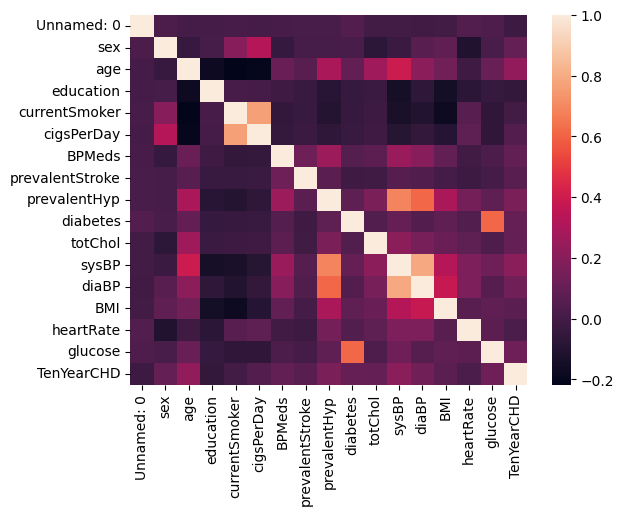

In [5]:
train_data_corr = train_data.corr()
sns.heatmap(train_data_corr)

We notice a few things by doing this. Firstly, what was presumably a column for IDing the patients is still included in the data ("Unnamed: 0"). This will have to be dropped. In addition, from the heat map we can see that while nothing correlates too strongly with the label (looking at the bottom row), education actually has the worst correlation near 0. We'll drop this as well.





In [6]:
train_data = train_data.drop(['Unnamed: 0', 'education'], axis=1)
test_data = test_data.drop(['Unnamed: 0', 'education'], axis=1)
cat_vars = ['sex', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

Moreover, the variables cigsPerDay, BPMeds, totChol, BMI, and glucose all have missing values. For the numeric variables, we'll handle this within our pipeline by using an imputer to calculate some value to replace the missing values with. This is a better option than dropping the rows with missing data since it means we'll still be able to use it to train. For the categorical variables with missing variables, there was only BPMeds after we dropped education. The categories for this variable was 0 and 1. To fill the NAs we replaced them with 0s since BPMeds represented a boolean, you either did take medication or you didn't and since the majority didn't (had 0), this was a suitable replacement for the missing values as well.

Additionally, for the categorial variables, we noticed that they are floats, not strings. This shouldn't be a problem, however, as we plan to use a OneHotEncoder anyways to transform the categorical data which should seperate the different distinct values regardless. This also solves our problem with missing values for them as well since NAs will just be represented as their own column in the resulting matrix.

Apart from these small observations, the numeric data will be transformed in the pipeline, as we said, and there were no other noticeable problems with the categorical data so there wasn't any more cleaning we chose to do.

In [7]:
train_data[['BPMeds']] = train_data[['BPMeds']].fillna(0)
test_data[['BPMeds']] = test_data[['BPMeds']].fillna(0)

## Results

### Model Pipeline

Here we are defining a function that given our categorical and numeric variables we select, creates pipelines for a LinearRegressor, Logistic Regressor, and DecisionTreeClassifier.

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

def pipe(cat_vars, num_vars):

    #set up variable preprocessing:
    X_vars = cat_vars + num_vars
    cat_pipeline = Pipeline(steps = [('ohc', OneHotEncoder(sparse_output=False))])
    num_pipeline = Pipeline(steps = [('maxmin', StandardScaler()), ('imputer', SimpleImputer(strategy='median'))])

    #column transformer:
    preprocessor = ColumnTransformer(transformers = [('cat', cat_pipeline, cat_vars), ('num', num_pipeline, num_vars)])

    #create model specific pipelines:
    lm_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('linreg', LinearRegression(fit_intercept=False))])
    lr_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('linreg', LogisticRegression())])
    tree_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('tree', DecisionTreeClassifier(max_depth = 4))])

    #split train-test data
    X_train = train_data.loc[:, X_vars]
    X_test = test_data.loc[:, X_vars]
    y_train = train_data[y]
    y_test = test_data[y]

    #fit the models
    lm = lm_pipe.fit(X_train, y_train)
    lr = lr_pipe.fit(X_train, y_train)
    tree = tree_pipe.fit(X_train, y_train)

    #results:

    # LINEAR REGRESSION

    print('Linear Model rsq: ', lm.score(X_test, y_test) ) # R-squared
    y_hat_lm = lm.predict(X_test) # Predicted values

    print('Slope Coefficients: ', lm_pipe.named_steps['linreg'].coef_) # Regression coefficients
    print('Intercept: ', lm_pipe.named_steps['linreg'].intercept_) # Regression coefficients

    plt.scatter(x=y_hat_lm, y=y_test)
    plt.title('Linear Model: Predicted vs. Actual Values')
    plt.show()

    # sns.scatterplot(x=y_test,y=y_hat_lm) 
    # plt.show()   

    sns.kdeplot(x=y_test - y_hat_lm).set_title('Linear Model: Residuals')
    plt.show()

    # LOGISTIC REGRESSION

    print(f'\nLogistic Regression rsq: {lr.score(X_test, y_test)}') # R-squared
    # plt.scatter(x=lr.predict_proba(X_test)[:,1], y=y_test)
    # plt.show()
    sns.regplot(x=lr.predict_proba(X_test)[:,1], y=y_test, data=train_data, logistic=True, ci=None)
    plt.show()
    
    # DECISION TREE

    print('\nTree rsq: ', tree.score(X_test, y_test) ) # R-squared
    y_hat_tree = tree.predict(X_test)

    tab = pd.crosstab(y_test,y_hat_tree) # Compute confusion matrix
    acc = (tab.iloc[0,0]+tab.iloc[1,1])/(tab.iloc[0,0]+tab.iloc[1,1]+tab.iloc[0,1]+tab.iloc[1,0]) # Compute Accuracy
    print('Accuracy: ', acc, '\n')
    print('Confusion Matrix:', '\n',pd.crosstab(y_test,y_hat_tree))



    plot_tree(tree_pipe.named_steps['tree'],filled=True)
    plt.show()

    # plt.scatter(x=y_hat_tree,y=y_test)
    # plt.title('Tree: Predicted vs. Actual Values')
    # plt.show()

    sns.kdeplot(x=y_test - y_hat_tree).set_title('Tree: Residuals')
    plt.show()


Linear Model rsq:  0.08794316910538147
Slope Coefficients:  [-8.47428421e+11 -8.47428421e+11 -6.08392792e+11 -6.08392792e+11
 -1.50399739e+12 -1.50399739e+12  2.06002934e+12  2.06002934e+12
 -3.40552103e+11 -3.40552103e+11  1.24034137e+12  1.24034137e+12
  5.87692261e-02  3.28979492e-02  1.20925903e-02  4.95166779e-02
 -1.74865723e-02 -1.93023682e-03  1.11389160e-03  2.63710022e-02]
Intercept:  0.0


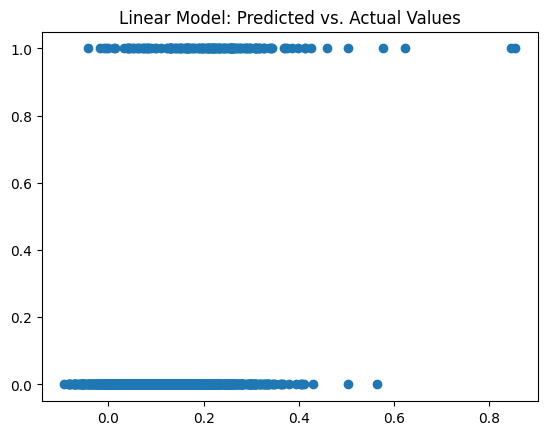

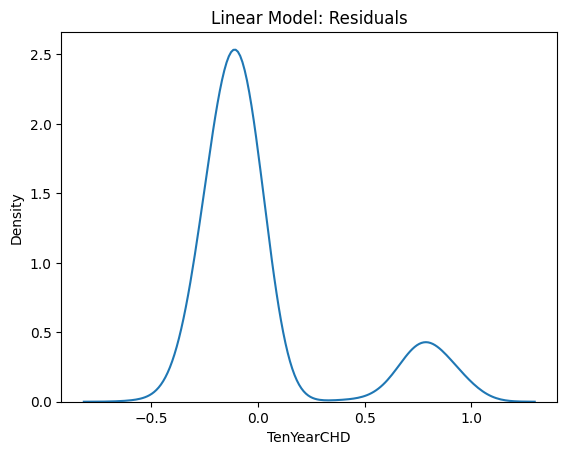


Logistic Regression rsq: 0.8603773584905661


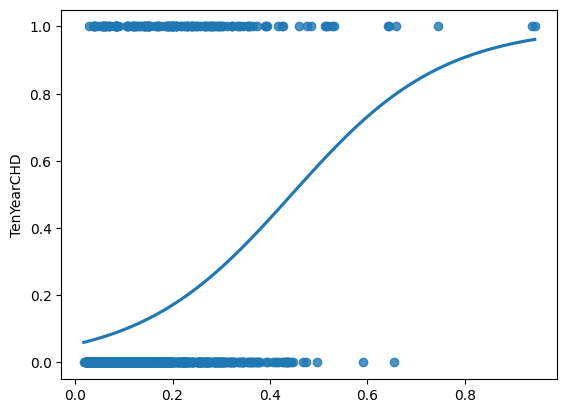


Tree rsq:  0.8443396226415094
Accuracy:  0.8443396226415094 

Confusion Matrix: 
 col_0         0   1
TenYearCHD         
0           888  15
1           150   7


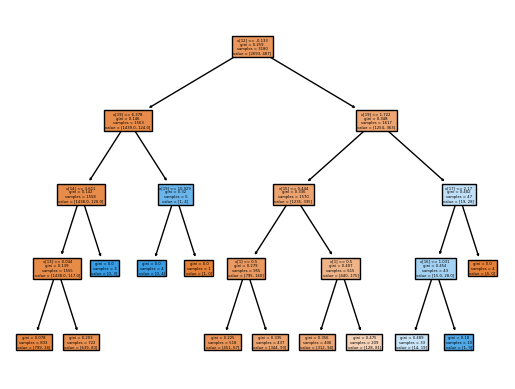

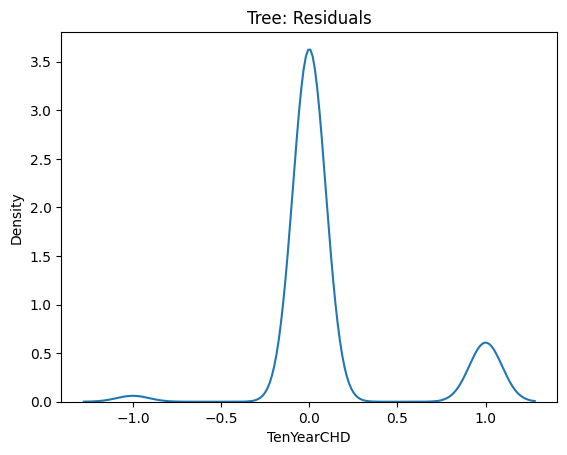

In [31]:
pipe(cat_vars, num_vars)

Here we can see with the variables we initially chose, the logistic regression model has the highest R-squared value of 0.85849 with the Decision Tree being very close at 0.84434

We then went on to try and look at how well do health conditions variables predict the possibility of getting CHD so we reduce the variables to only those relating to health

> Add blockquote



Linear Model rsq:  0.06467484480883523
Slope Coefficients:  [-1.44881748e+12 -1.44881748e+12  1.44881748e+12  1.44881748e+12
  2.07970142e-02  7.44018555e-02 -2.66590118e-02  1.84726715e-03
 -6.35528564e-03  3.60488892e-02]
Intercept:  0.0


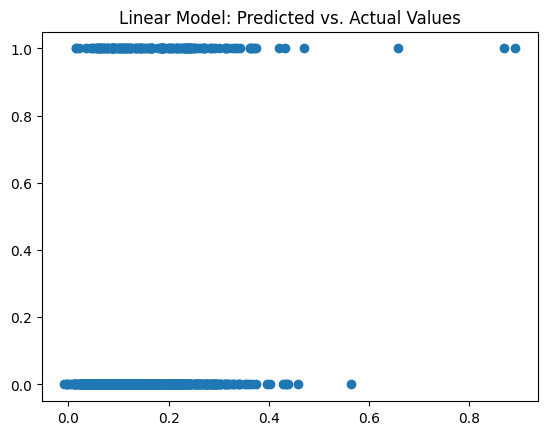

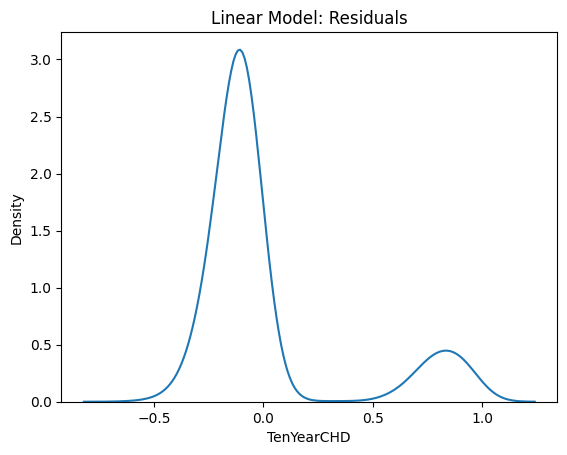


Logistic Regression rsq: 0.8518867924528302


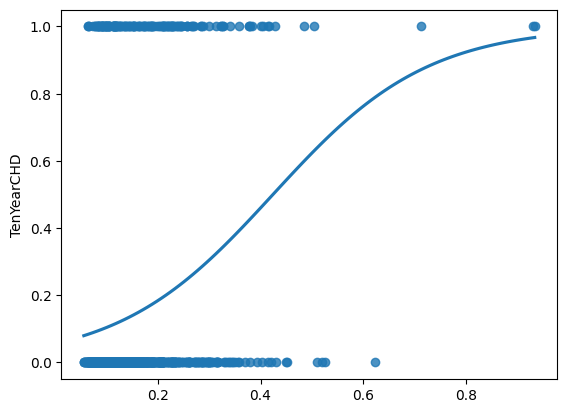


Tree rsq:  0.8452830188679246
Accuracy:  0.8452830188679246 

Confusion Matrix: 
 col_0         0   1
TenYearCHD         
0           889  14
1           150   7


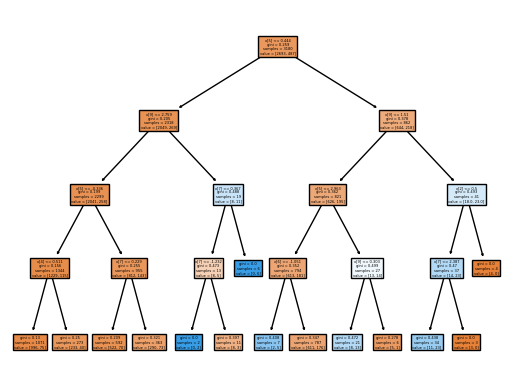

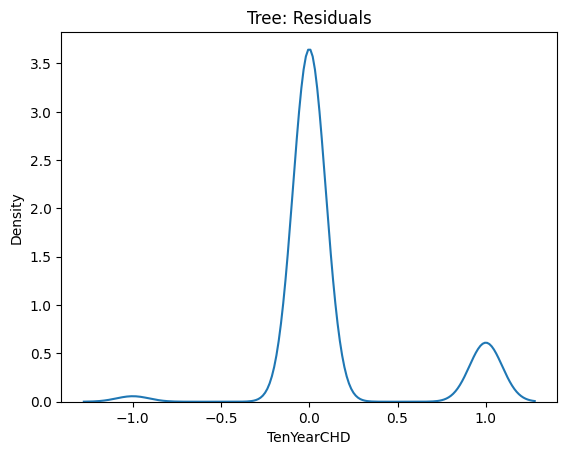

In [32]:
# cat_vars = ['sex', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
# num_vars = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

pipe(['prevalentStroke', 'prevalentHyp'], ['totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'])



Lastly, we examined how much does stroke prevalency and heart rate predict the possibility of getting CHD. The only variables used here were prevalentStroke and heartRate.


Linear Model rsq:  0.003861077403707891
Slope Coefficients:  [0.15129597 0.43124024 0.00891029]
Intercept:  0.0


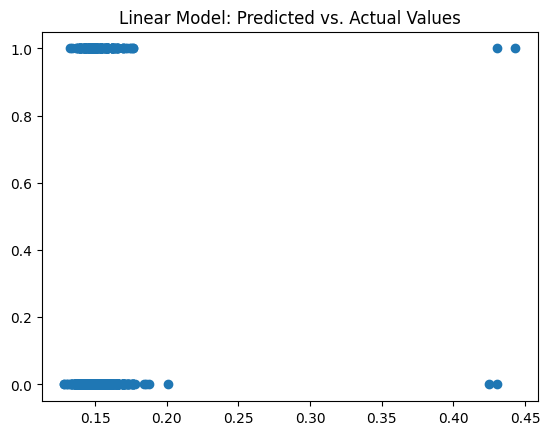

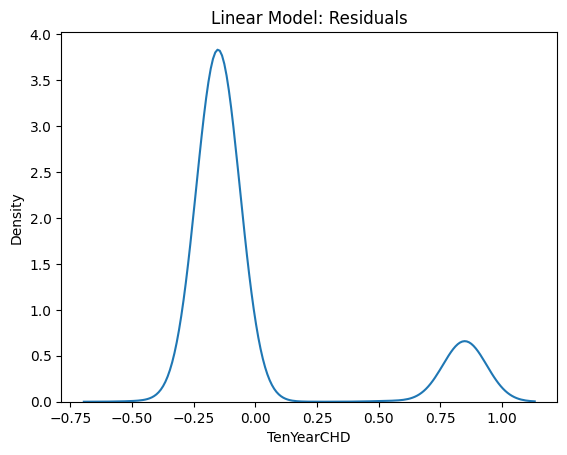


Logistic Regression rsq: 0.8518867924528302


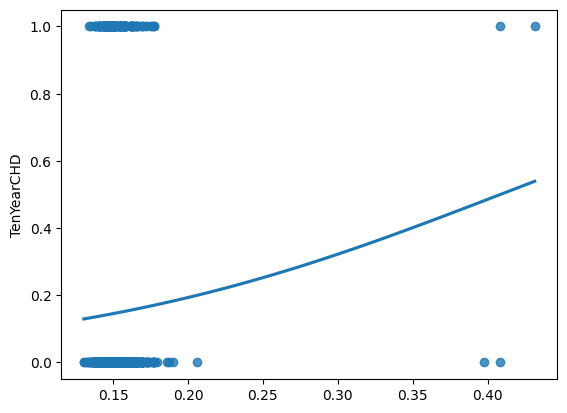


Tree rsq:  0.8528301886792453
Accuracy:  0.8528301886792453 

Confusion Matrix: 
 col_0         0  1
TenYearCHD        
0           903  0
1           156  1


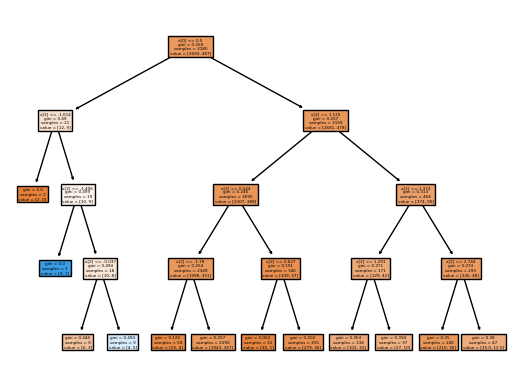

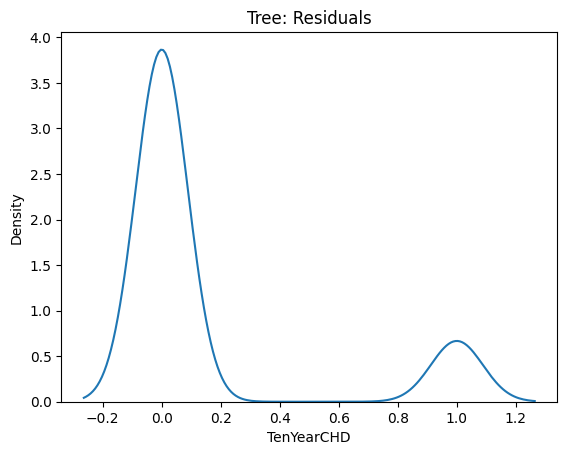

In [33]:
pipe(['prevalentStroke'], ['heartRate'])

## Conclusion

Overall we found that